In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
%matplotlib notebook
import random
from os import listdir, mkdir, getcwd
from os.path import isfile, join, isdir


In [2]:
skip_rows = 18 #number of rows to skip in the header file
bin_num = 0 #enter 0 for maximum bin number; else enter some other number


file_loc = 'C:\\Data\\2020\\08\\20200827\\spectra\\'
save_loc = getcwd().replace("\\", r"/") + r'/plots/'

b_field = '4.0'
title_str = 'aDs8a5m2b2' #Autopopulates with date, x-axis, binnum, magnetic field, number scans
x_wavelength = True #if true, plot x axis in wavelength, if false, plot in frequeny
saveplot = True

In [3]:
#grab and bin data

def grab_data(datfile):
    wavelength, N = np.loadtxt(datfile, unpack=True, skiprows=skip_rows)
    data = np.zeros([2, len(wavelength)])
    data[0,:] = wavelength
    data[1,:] = N
    
    
        
    #Don't plot initialization 0's
    mask = (data==0).all(0)
    start_idx = np.argmax(~mask)
    data = data[:,start_idx:]
    return data

def bin_data(data, dmin, dmax,bn):
    binnedData = np.zeros([2,len(data[0,:])])
    wvlnList = np.linspace(dmin, dmax, bn)  

    for m in range(len(data[0,:])):
        ind = np.searchsorted(wvlnList, data[0,m])
        binnedData[0,m] = wvlnList[ind]
        binnedData[1,m] = data[1,m]
    
    #below useful for combining with other binnedData sets down the line
    setdif = np.setdiff1d(wvlnList, binnedData[0,:])
    for i, sd in enumerate(setdif):
        binnedData = np.append(binnedData, [[sd],[np.NaN]], axis=1)
   
    return binnedData
            
            
def ave_data(bd):
#average binned data and grab standard deviations for uncertainties 
    xs = bd[0,:]
    ys = bd[1,:]

    avexs = np.unique(bd[0,:])
    aveys = np.empty(avexs.shape)
    stdys = np.empty(avexs.shape)

    for i, x in enumerate(avexs):
        aveys[i] = np.mean(ys[xs == x])

    for i, x in enumerate(avexs):
        stdys[i] = np.std(ys[xs == x])


    aveBinnedData = np.empty([2, len(avexs)])
    aveBinnedData[0,:] = avexs
    aveBinnedData[1,:] = aveys
    
    aveys = np.where(aveys == 0, 1, aveys) 
    dN = stdys/np.sqrt(aveys)
    for i, value in enumerate(dN):
        if value == 0:
            dN[i] = 1.14 
    
    return aveBinnedData, dN

In [12]:
#grab data from multiple datasets
field = b_field
mypath = file_loc

datfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
datlist = list()

for df in datfiles:    
    if df.find('.dat')!=-1 and df.find('collected') == -1: #substring in string
        #e.g., datfile = '2020_07_26_scans/20200725-2244-48_scan_vac_wavelength_test_aDs8a6m2b2_clines_3.2kG_1570nW_45deg__binned0.dat'
        datlist.append(mypath + "/" + df)


    title_date_str = datfiles[0].split("-")[0]
print(datlist)

['C:\\Data\\2020\\08\\20200827\\spectra\\/20200827-0908-40_scan_vac_wavelength_aDs8a5m2b2_350nW_27.26deg_raw.dat', 'C:\\Data\\2020\\08\\20200827\\spectra\\/20200827-0912-21_scan_vac_wavelength_aDs8a5m2b2_350nW_27.26deg_raw.dat', 'C:\\Data\\2020\\08\\20200827\\spectra\\/20200827-0914-08_scan_vac_wavelength_aDs8a5m2b2_350nW_27.26deg_raw.dat', 'C:\\Data\\2020\\08\\20200827\\spectra\\/20200827-0918-47_scan_vac_wavelength_aDs8a5m2b2_350nW_27.26deg_raw.dat']


In [13]:
def limitvals(dl):
    minwvlns = np.zeros(len(dl))
    maxwvlns = np.zeros(len(dl))
    binnums = np.zeros(len(dl))
    
    for i, d in enumerate(dl):
        wavelength, N = np.loadtxt(d, unpack=True, skiprows=10)
        minwvlns[i] = min(wavelength)
        maxwvlns[i] = max(wavelength)
        binnums[i] = len(np.unique(wavelength))

    return min(minwvlns), max(maxwvlns), int(min(binnums))

def smoosh_arrays(dl):
    dmin, dmax, bn = limitvals(dl)
    if bin_num != 0 and bin_num < bn:
        bn = bin_num
    
    arr = list()
    for d in dl:
        dat = grab_data(d)
        
        bd = bin_data(dat, dmin, dmax, bn)        
        avg2, dN = ave_data(bd)

        arr.append(avg2[1,:])
    return arr, avg2[0,:]


sm, xs = smoosh_arrays(datlist)

means = np.nanmean(sm, axis=0)
stds = np.nanstd(sm, axis=0)/np.sqrt(len(datlist))
print(len(xs))
print(len(means))
print(len(stds))
print(np.sqrt(len(datlist)))

1232
1232
1232
2.0


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


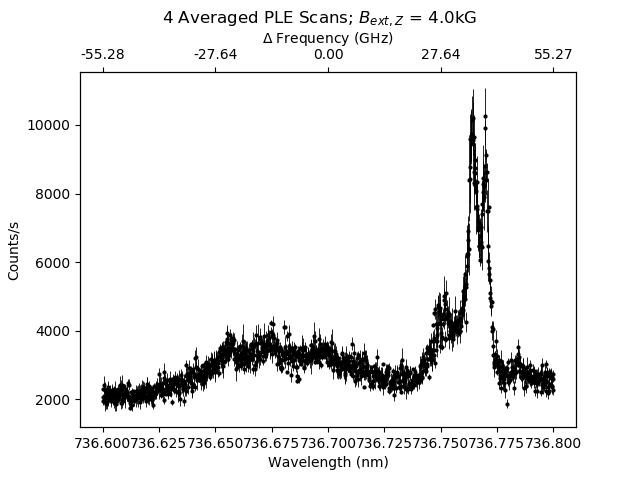

[736.59996   736.6499925 736.700025  736.7500575 736.80009  ]


In [14]:
%matplotlib notebook
B = field
numScans = len(datlist)


if x_wavelength: 
    xaxstr = "x-wavelength"
else: 
    xaxstr = "x-freq"
    
bn = len(xs)
    
t_str = title_date_str + '_' + title_str + '_'+ xaxstr + "_binnum-"+ str(bn)


channel = xs
N = means
dN = stds


fig = plt.figure()

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

c = 299792458
aveWvln = (max(xs)+min(xs))/2
aveFreq = (c/(aveWvln*10**-9))*10**-9

if x_wavelength: 
    ax.errorbar(channel, N, dN, fmt='ko', markersize=2 ,elinewidth = .6,zorder=1) 
    ax.set_xlabel('Wavelength (nm)')
    quarterw = (min(xs) + aveWvln)/2
    threequarterw = (max(xs) + aveWvln)/2
    topticklocs = np.array([min(xs), quarterw, aveWvln, threequarterw, max(xs)])

else: 
    ax.errorbar((c/(channel*10**-9))*10**-9, N, dN, fmt='ko', markersize=2 ,elinewidth = .6,zorder=1) 
    ax.set_xlabel('Frequency (GHz)')
    minf = min(c/(channel*10**-9))*10**-9
    maxf = max(c/(channel*10**-9))*10**-9
    quarterf = (minf + aveFreq)/2
    threequarterf = (maxf + aveFreq)/2
    topticklocs = np.array([minf, quarterf, aveFreq, threequarterf, maxf])


    
    
ax2 = ax.twiny()

def tick_function(X, wvln):
    if wvln: 
        V = aveFreq - (c/(X*10**-9))*10**-9
    else:
        V = X - aveFreq
    return ["%.2f" % z for z in V]
        
ax2.set_xlim(ax.get_xlim())

print(topticklocs)

ax2.set_xticks(topticklocs)
ax2.set_xticklabels(tick_function(topticklocs, x_wavelength))

ax2.set_xlabel(r"$\Delta$ Frequency (GHz)")

fg = plt.gcf()
fig.suptitle(str(numScans)+' Averaged PLE Scans; $B_{ext,Z}$ = ' + str(B) + 'kG', x=0.5, y=.98)


ax.set_ylabel('Counts/s')


if saveplot: 
    if not isdir(save_loc): 
        mkdir(save_loc)
    plt.savefig(save_loc + t_str + '_' + str(B) +'kG_'+ str(numScans) +'numscans_'+'avgdScans.pdf')
plt.show()


In [16]:
def lorentzian(x, p0, p1, p2):
    return p0*((p1/2)**2/((x-p2)**2 + (p1/2)**2))

pguess = [3500, .1, 406973]

c = 299792458

fitchan = c/(channel*10**-9)*10**-9

fitminx = 406971
fitmaxx = 406974
minchan = min(range(len(fitchan)), key = lambda i: abs(fitchan[i] - fitminx))
maxchan = min(range(len(fitchan)), key = lambda i: abs(fitchan[i] - fitmaxx))

rmin = min(minchan, maxchan)
rmax = max(minchan, maxchan)

fitchannel = fitchan[rmin:rmax]
fitN = N[rmin:rmax]

print(fitchan[minchan])
print(fitchan[maxchan])

print(minchan)
print(maxchan)



popt, pcov = curve_fit(lorentzian, fitchannel, fitN, p0=pguess)
print(popt)

406970.9593555505
406974.013168661
267
233
[2.72679387e+03 1.69529744e+01 4.06971665e+05]


<IPython.core.display.Javascript object>


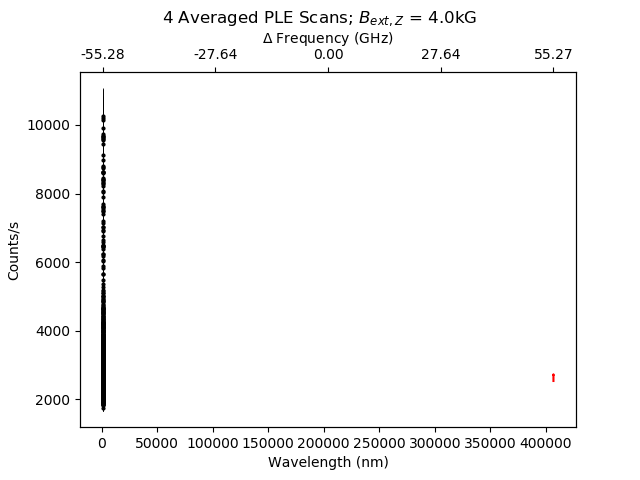

[736.59996   736.6499925 736.700025  736.7500575 736.80009  ]


In [17]:

%matplotlib notebook
B = field
numScans = len(datlist)
show_fit = False

if x_wavelength: 
    xaxstr = "x-wavelength"
else: 
    xaxstr = "x-freq"
    
bn = len(xs)
    
t_str = title_date_str + '_' + title_str + '_'+ xaxstr + "_binnum-"+ str(bn)


channel = xs
N = means
dN = stds


fig = plt.figure()

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)


c = 299792458
aveWvln = (max(xs)+min(xs))/2
aveFreq = (c/(aveWvln*10**-9))*10**-9

if x_wavelength: 
    ax.errorbar(channel, N, dN, fmt='ko', markersize=2 ,elinewidth = .6,zorder=1) 
    ax.set_xlabel('Wavelength (nm)')
    quarterw = (min(xs) + aveWvln)/2
    threequarterw = (max(xs) + aveWvln)/2
    topticklocs = np.array([min(xs), quarterw, aveWvln, threequarterw, max(xs)])

else: 
    ax.errorbar((c/(channel*10**-9))*10**-9, N, dN, fmt='ko', markersize=2 ,elinewidth = .6,zorder=1) 
    ax.set_xlabel('Frequency (GHz)')
    minf = min(c/(channel*10**-9))*10**-9
    maxf = max(c/(channel*10**-9))*10**-9
    quarterf = (minf + aveFreq)/2
    threequarterf = (maxf + aveFreq)/2
    topticklocs = np.array([minf, quarterf, aveFreq, threequarterf, maxf])


    
    
ax2 = ax.twiny()

def tick_function(X, wvln):
    if wvln: 
        V = aveFreq - (c/(X*10**-9))*10**-9
    else:
        V = X - aveFreq
    return ["%.2f" % z for z in V]
        
ax2.set_xlim(ax.get_xlim())

print(topticklocs)

ax2.set_xticks(topticklocs)
ax2.set_xticklabels(tick_function(topticklocs, x_wavelength))

ax2.set_xlabel(r"$\Delta$ Frequency (GHz)")

fg = plt.gcf()
fig.suptitle(str(numScans)+' Averaged PLE Scans; $B_{ext,Z}$ = ' + str(B) + 'kG', x=0.5, y=.98)


ax.set_ylabel('Counts/s')

if show_fit: 
    chan = np.linspace(min(fitchannel), max(fitchannel), 5000)
    ax.plot(chan, lorentzian(chan, popt[0], popt[1], popt[2]), 'r-', label='Fit', zorder = 10)

plt.show()